# 텐서플로 시작하기
- p120

## 상수 텐서와 변수
- 모두 1이거나 0인 텐서를 만들자

In [1]:
import tensorflow as tf
x = tf.ones(shape=(2, 1))
x

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[1.],
       [1.]], dtype=float32)>

In [2]:
x = tf.zeros(shape=(2, 1))
x

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.],
       [0.]], dtype=float32)>

## 랜덤 텐서

In [3]:
x = tf.random.normal(shape=(3, 1), mean = 0., stddev= 1.)
print(x)

tf.Tensor(
[[ 1.5235001 ]
 [-0.24085173]
 [-1.0221515 ]], shape=(3, 1), dtype=float32)


In [5]:
x = tf.random.uniform(shape=(3, 1), minval = 0., maxval=1.)
print(x)

tf.Tensor(
[[0.78840363]
 [0.37183225]
 [0.08137286]], shape=(3, 1), dtype=float32)


## 값 할당

In [6]:
import numpy as np
x = np.ones(shape=(2, 2))
x[0, 0] = 0.
x

array([[0., 1.],
       [1., 1.]])

In [7]:
x = tf.ones(shape=(2, 2))
x[0, 0] = 0. # 할당 없음

TypeError: ignored

In [8]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[ 1.9804772],
       [ 1.1687381],
       [-1.1539693]], dtype=float32)>


In [10]:
v.assign(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

In [12]:
v[0, 0].assign(3.)

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>

In [13]:
v.assign_add(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>

## 텐서 연산 : 텐서플로에서 사칙연산

In [19]:
a = tf.ones((2, 2))
b = tf.square(a) # 제곱 계산
c = tf.sqrt(a) # 제곱근 계산
d = b + c # 두 텐서 더하기
e = tf.matmul(a, d)
e *= d
e

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[8., 8.],
       [8., 8.]], dtype=float32)>

# GradientTape API 살펴보기
- 텐서플로 numpy와 비슷
  + 미분가능하게 만들어줌 (텐서플로 O, numpy X)

In [20]:
input_var = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape:
   result = tf.square(input_var)
gradient = tape.gradient(result, input_var)

In [21]:
input_const = tf.constant(3.)
with tf.GradientTape() as tape:
   tape.watch(input_const)
   result = tf.square(input_const)
gradient = tape.gradient(result, input_const)

In [22]:
time = tf.Variable(0.)
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        position =  4.9 * time ** 2
    speed = inner_tape.gradient(position, time)
acceleration = outer_tape.gradient(speed, time)

# 엔드-투-엔드 예제
- 텐서플로 선형 분류기


## 2D 평면에 두 클래스 데이터 생성

In [24]:
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean = [0, 3], # x축의 위치를 살짝 조정
    cov = [[1, 0.5], [0.5, 1]], # 데이터 방향이 우상향
    size = num_samples_per_class
)

positive_samples = np.random.multivariate_normal(
    mean = [3, 0], # x축의 위치를 살짝 조정
    cov = [[1, 0.5], [0.5, 1]], # 데이터 방향이 우상향
    size = num_samples_per_class
)

array([[ 0.93715822,  2.26072787],
       [ 2.20744976,  3.23663322],
       [-0.63474174,  3.47447904],
       ...,
       [-0.8137665 ,  2.54497162],
       [-1.24225634,  2.85181893],
       [ 1.10403585,  4.21140161]])

In [25]:
positive_samples.dtype

dtype('float64')

## 두 데이터 합치기

In [27]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)
inputs.shape

(2000, 2)

## 0과 1로 구성된 타겟 생성

In [28]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))
targets.shape

(2000, 1)

## 그래프 그려보기

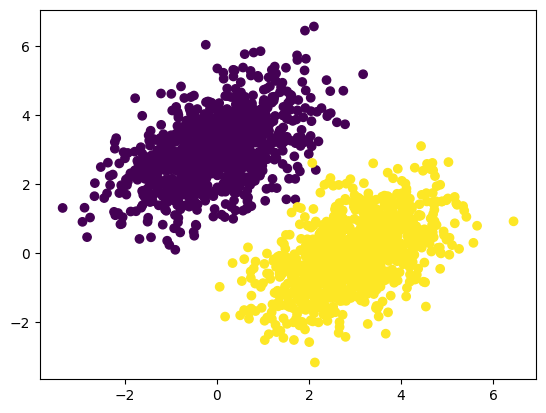

In [29]:
import matplotlib.pyplot as plt
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

p.127
- 선형 분류기
  = prediction = w * input + b

In [32]:
input_dim = 2 # 입력은 2차원 배열
output_dim = 1 # 출력 예측은 하나의 점수, 0에 가까우면 0, 1에 가까우면 1
W = tf.Variable(initial_value = tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value = tf.zeros(shape=(output_dim, )))

<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>

## 정방향 패스 함수

In [33]:
def model(inputs):
  return tf.matmul(inputs, W) + b

## 평균 제곱 오차 손실 함수

In [36]:
def square_loss(targets, predictions):
  per_sample_losses = tf.square(targets - predictions) # 각 샘플의 손실 값을 담고 있다.
  return tf.reduce_mean(per_sample_losses) # 샘플당 손실 값으로 하나의 스칼라 손실 값으로 평균

## 훈련 스텝 함수
- 순전파 계산(=정방향 계산)
- 역전파 계산
- 가중치를 업데이트 = 기울기 변동 = 오차를 감소시키기 위한 목적

In [34]:
learning_rate = 0.1 # step
def training_step(inputs, targets):
  with tf.GradientTape() as tape: # 정방향 계산, 순전파 계산
    predictions = model(inputs)
    loss = square_loss(targets, predictions)
  # 역전파 수행 중, 각각의 업데이트 된 기울기(=가중치)
  grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
  W.assign_sub(grad_loss_wrt_W * learning_rate) # 가중치 업데이트
  b.assign_sub(grad_loss_wrt_b * learning_rate) # 회귀식으로 따지면 절편

  return loss

## 배치 훈련 루프

In [37]:
for step in range(40):
    loss = training_step(inputs, targets)
    print(f"{step}번째 스텝의 손실: {loss:.4f}")

0번째 스텝의 손실: 1.7043
1번째 스텝의 손실: 0.1255
2번째 스텝의 손실: 0.0941
3번째 스텝의 손실: 0.0860
4번째 스텝의 손실: 0.0804
5번째 스텝의 손실: 0.0755
6번째 스텝의 손실: 0.0710
7번째 스텝의 손실: 0.0669
8번째 스텝의 손실: 0.0632
9번째 스텝의 손실: 0.0598
10번째 스텝의 손실: 0.0567
11번째 스텝의 손실: 0.0539
12번째 스텝의 손실: 0.0513
13번째 스텝의 손실: 0.0489
14번째 스텝의 손실: 0.0467
15번째 스텝의 손실: 0.0448
16번째 스텝의 손실: 0.0430
17번째 스텝의 손실: 0.0413
18번째 스텝의 손실: 0.0398
19번째 스텝의 손실: 0.0384
20번째 스텝의 손실: 0.0372
21번째 스텝의 손실: 0.0360
22번째 스텝의 손실: 0.0350
23번째 스텝의 손실: 0.0341
24번째 스텝의 손실: 0.0332
25번째 스텝의 손실: 0.0324
26번째 스텝의 손실: 0.0317
27번째 스텝의 손실: 0.0310
28번째 스텝의 손실: 0.0304
29번째 스텝의 손실: 0.0298
30번째 스텝의 손실: 0.0293
31번째 스텝의 손실: 0.0289
32번째 스텝의 손실: 0.0285
33번째 스텝의 손실: 0.0281
34번째 스텝의 손실: 0.0277
35번째 스텝의 손실: 0.0274
36번째 스텝의 손실: 0.0271
37번째 스텝의 손실: 0.0268
38번째 스텝의 손실: 0.0266
39번째 스텝의 손실: 0.0264


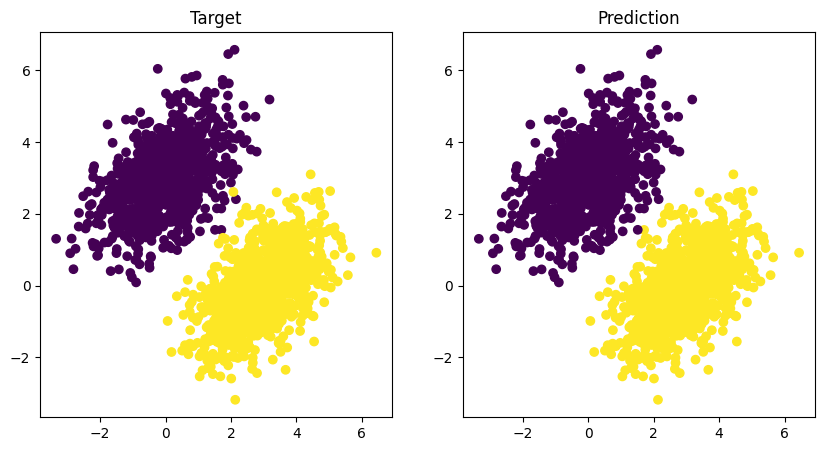

In [40]:
predictions = model(inputs)

fig, ax = plt.subplots(ncols = 2, figsize=(10, 5))

ax[0].scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
ax[0].set_title("Target")
ax[1].scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
ax[1].set_title("Prediction")
plt.show()

## 직선 긋기

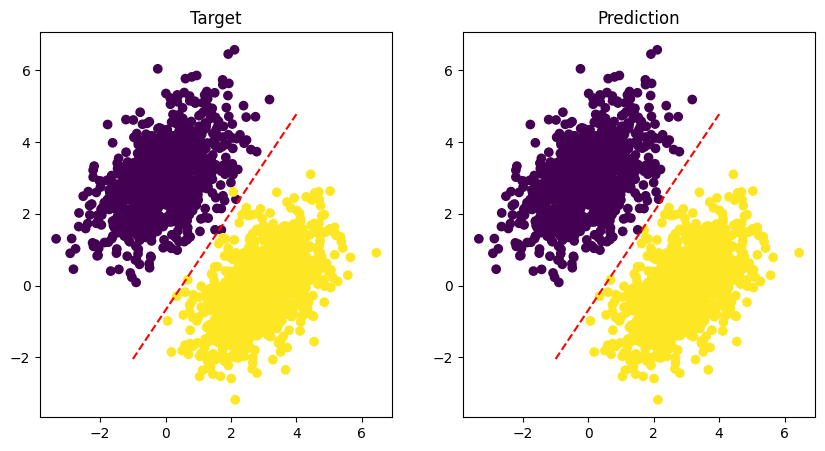

In [42]:
x = np.linspace(-1, 4, 100)
# 사실 100개의 x 축 좌표를 만들 필요 없이 시작과 종료 위치만 있어도 됩니다.
# x = [-1, 4]
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]

fig, ax = plt.subplots(ncols = 2, figsize=(10, 5))

ax[0].scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
ax[0].set_title("Target")
ax[0].plot(x, y, '--r')
ax[1].scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
ax[1].set_title("Prediction")
ax[1].plot(x, y, '--r')
plt.show()

# 영화 리뷰 분류 : 이진 분류 문제
- p.147

In [43]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17464789/17464789 [==============================] - 1s 0us/step


In [47]:
train_data[0][:3] # 형태소 분석, 텍스트 마이닝 할 때 나오는 숫자 개념

[1, 14, 22]

In [49]:
train_labels[0] # 부정적인 문장 0, 긍정적인 문장 1

1

In [55]:
len(train_data[0]), len(train_data[1])

(218, 189)

In [51]:
max([max(sequence) for sequence in train_data]) # 가장 자주 등장하는 단어 1만개로 제한

9999

In [53]:
word_index = imdb.get_word_index()
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])

decode_review = " ".join(
    [reverse_word_index.get(i-3, "?") for i in train_data[1]]
)

decode_review

"? big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal ? the hair is big lots of boobs ? men wear those cut ? shirts that show off their ? sickening that men actually wore them and the music is just ? trash that plays over and over again in almost every scene there is trashy music boobs and ? taking away bodies and the gym still doesn't close for ? all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then"

## 정수 시퀀스를 멀티-핫 인코딩으로 인코딩
- p.149
  + 텍스트 데이터는, 문장 길이가 다 달라서, 바로 행렬로 변환이 어렵다
    + 방법 1: 같은 길이가 되도록 리스트에 패딩0을 추가
    + 방법 2: 멀티- 핫 인코딩, 0과 1의 벡터로 변환

In [56]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    for j in sequence:
      results[i, j] = 1.

  return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [61]:
len(train_data[0]), len(train_data[1])

(218, 189)

In [60]:
len(x_train[0]), len(x_train[1])

(10000, 10000)

In [58]:
x_train.shape

(25000, 10000)

In [59]:
x_test.shape

(25000, 10000)

## y값 벡터 변환

In [62]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

## 신경망 모델 만들기
- Dense 층을 쌓기
  + 얼마나 많은 층을 사용할 것인가?
  + 각층에 얼마나 많은 은닉층을 사용할 것인가?
  + 얼마나 많은 unit

In [65]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# 모델 컴파일하기
model.compile(
    optimizer="rmsprop", # SGD 확률적 경사하강법
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

## 훈련 검증

In [66]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

## 모델 훈련

In [67]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

vis(history)

Epoch 1/20
30/30 [==============================] - 4s 58ms/step - loss: 0.5231 - accuracy: 0.7824 - val_loss: 0.3979 - val_accuracy: 0.8627
Epoch 2/20
30/30 [==============================] - 1s 25ms/step - loss: 0.3263 - accuracy: 0.8920 - val_loss: 0.3316 - val_accuracy: 0.8739
Epoch 3/20
30/30 [==============================] - 1s 23ms/step - loss: 0.2458 - accuracy: 0.9197 - val_loss: 0.2904 - val_accuracy: 0.8854
Epoch 4/20
30/30 [==============================] - 1s 25ms/step - loss: 0.1970 - accuracy: 0.9348 - val_loss: 0.2998 - val_accuracy: 0.8807
Epoch 5/20
30/30 [==============================] - 1s 23ms/step - loss: 0.1653 - accuracy: 0.9450 - val_loss: 0.2850 - val_accuracy: 0.8844
Epoch 6/20
30/30 [==============================] - 1s 36ms/step - loss: 0.1426 - accuracy: 0.9535 - val_loss: 0.2837 - val_accuracy: 0.8870
Epoch 7/20
30/30 [==============================] - 1s 33ms/step - loss: 0.1206 - accuracy: 0.9617 - val_loss: 0.2933 - val_accuracy: 0.8855
Epoch 8/20
30

In [68]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## 훈련과 검증 손실 그리기
- 해당 코드 함수화 할 것
  + 미니 과제

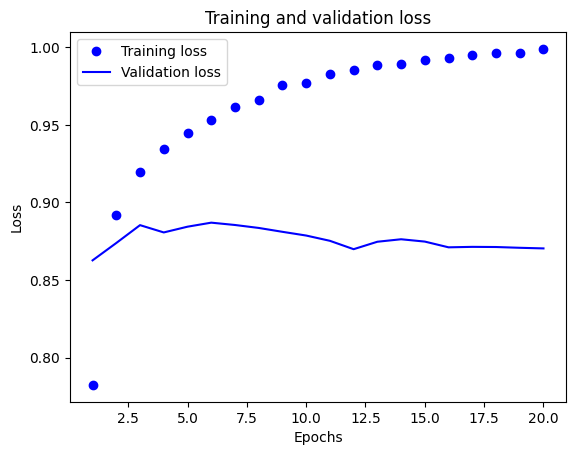

In [73]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["accuracy"]
val_loss_values = history_dict["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()